In [2]:
#Author: Chi-Wei Chiang
#需事先安裝的套件
#pip install scikit-tensor-py3
#pip install tensorly

In [1]:
#載入資料集
import h5py
with h5py.File('usps.h5', 'r') as hf:
    train = hf.get('train')
    X_tr = train.get('data')[:]
    y_tr = train.get('target')[:]
    test = hf.get('test')
    X_te = test.get('data')[:]
    y_te = test.get('target')[:]

#顯示train資料集的數量資訊
#train.data資料集的內容是7291張照片，照片大小256=16*16
#train.target資料集的內容是7291張照片分別對應的數字
print('train.data.shape=', X_tr.shape, ', train.target.shape=', y_tr.shape)

train.data.shape= (7291, 256) , train.target.shape= (7291,)


In [2]:
import tensorflow as tf
import numpy as np

#把圖片資料分類，放在digits二維矩陣裡面
#數字0的照片就放在digits[0]，數字1的照片就放在digits[1]，依此類推...
digits = [[] for _ in range(10)]
for item in zip(y_tr, X_tr):
    dig = item[0] # dig=6
    img = item[1].reshape(16, 16) ###讀取預設為長度256的向量，轉成16*16矩陣
    digits[dig].append(img)

#列表顯示圖片數量
imgTotal = 0
for i in range(10):
    lenOfImg = len(digits[i])
    print('數字:', i, ', 圖片數量=', lenOfImg)
    imgTotal += lenOfImg
print('-----------------------\n', '         總數量 =', imgTotal)

數字: 0 , 圖片數量= 1194
數字: 1 , 圖片數量= 1005
數字: 2 , 圖片數量= 731
數字: 3 , 圖片數量= 658
數字: 4 , 圖片數量= 652
數字: 5 , 圖片數量= 556
數字: 6 , 圖片數量= 664
數字: 7 , 圖片數量= 645
數字: 8 , 圖片數量= 542
數字: 9 , 圖片數量= 644
-----------------------
          總數量 = 7291


In [5]:
from sktensor import dtensor
from sktensor import tucker

def letsHosvd(n):
    #指定An=數字n的圖片陣列 (131*16*16)
    An = digits[n]

    #把 An轉置成跟課本一樣的維度 (16*16*131)
    Ant = np.transpose(An, (1,2,0))

    #把 Ant轉成 Tensor A，才能使用hosvd方法
    A = dtensor(Ant)


    #把轉換後的 tensor 進行 HOSVD分解: A = S x1 U1 x2 U2 x3 U3
    # S: core tensor
    # U1, U2, U3: 特徵矩陣
    return tucker.hosvd(A, A.shape)


In [7]:
from tensorly import fold, unfold

def findAi(U, S):
    #計算 S x1 U1
    S_x1U1 = fold(U[0].dot(unfold(S, 0)), 0, S.shape)
    #print('<S x1 U1>.shape=', S_x1U1.shape)

    #計算 S x1 U1 x2 U2
    S_x1U1_x2U2 = fold(U[1].dot(unfold(S_x1U1, 1)), 1, S.shape)
    #print('<S x1 U1 x2 U2>.shape=', S_x1U1_x2U2.shape)

    A1 = S_x1U1_x2U2[:,:,0] #mean value of different 3's
    A2 = S_x1U1_x2U2[:,:,1] #the dominating directions of variation from the "mean value"
    A3 = S_x1U1_x2U2[:,:,2] #the dominating directions of variation from the "mean value"
    
    return A1, A2, A3

In [8]:
Ac = [[] for _ in range(10)] #宣告二維陣列
for i in range(10): #數字i從0到9，算每個數字的A1、A2、A3
    u, s = letsHosvd(i)
    A1, A2, A3 = findAi(u, s)
    Ac[i].append(A1) #數字 i的A1
    Ac[i].append(A2) #數字 i的A2
    Ac[i].append(A3) #數字 i的A3

In [10]:
def calcZi(pZ, pA):
    return np.tensordot(pZ, pA) / np.tensordot(pA, pA)

def recognize(pZ, pA):
    result = -1
    residual = 0
    for i in range(10):
        #取出A1、A2、A3
        A1 = pA[i][0]
        A2 = pA[i][1]
        A3 = pA[i][2]
        
        #計算z1、z2、z3，z是純量數值
        z1 = calcZi(pZ, A1)
        z2 = calcZi(pZ, A2)
        z3 = calcZi(pZ, A3)
        
        #把zi跟Ai分別相乘
        z1A1 = z1*(A1)
        z2A2 = z2*(A2)
        z3A3 = z3*(A3)
        
        #求距離r
        r = np.linalg.norm(pZ-(z1A1+z2A2+z3A3), ord='fro')
        
        #如果距離比上次計算更小，表示這次結果更接近
        if (r < residual or result == -1):
            result = i
            residual = r
    
    return result

答對= 1802 , 答錯= 205 , 辨認率= 0.898 %

辨認錯誤情形參考如下(前10次比對):


<Figure size 432x288 with 0 Axes>

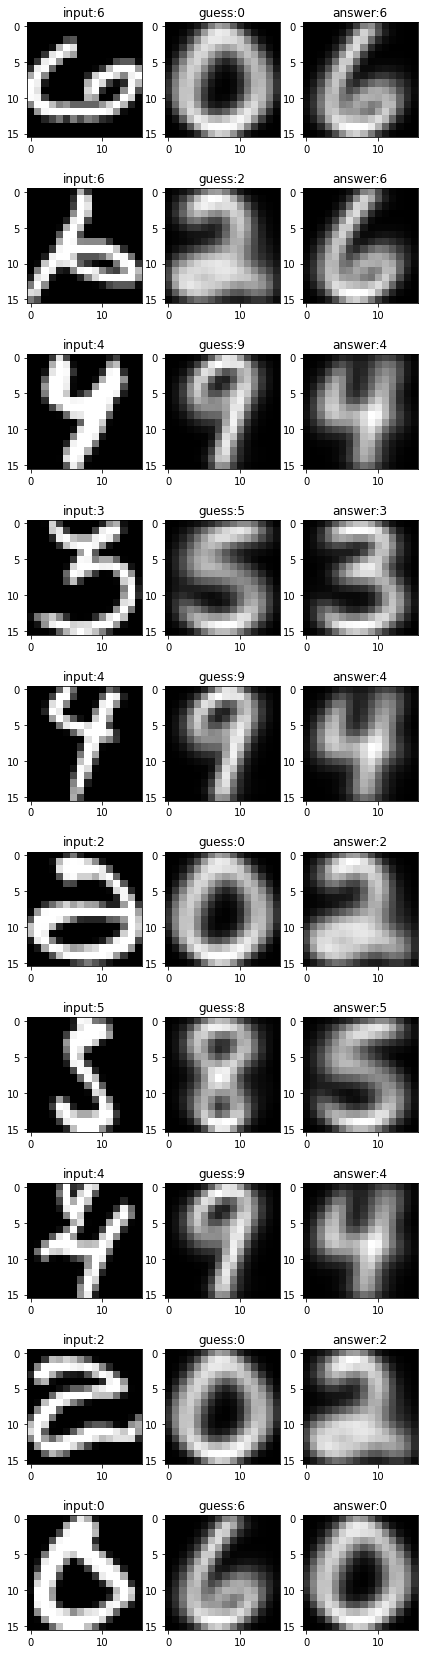

In [11]:
import matplotlib.pyplot as plt
plt.gray()
fig, ax = plt.subplots(10,3,figsize = (7,30))

correct = 0
wrong = 0

for item in zip(y_te, X_te):
    teImg = item[1].reshape(16, 16)
    result = recognize(teImg, Ac)
    if (result == item[0]):
        correct += 1
    else:
        if (wrong < 10):
            ax[wrong][0].set(title = "input:" + str(item[0]))
            ax[wrong][0].imshow(teImg)
            ax[wrong][1].set(title = "guess:" + str(result))
            ax[wrong][1].imshow(Ac[result][0].reshape(16, 16))
            ax[wrong][2].set(title = "answer:" + str(item[0]))
            ax[wrong][2].imshow(Ac[item[0]][0].reshape(16, 16))
        wrong += 1

print('答對=', correct, ', 答錯=', wrong, ', 辨認率=', np.round(correct/(correct+wrong), 3), '%\n')
print('辨認錯誤情形參考如下(前10次比對):')